# 課題整理

## 3パターンのクーポン発行
1. セールのチラシのみ
1. セールのチラシと1,000円のクーポン
1. セールのチラシと2,000円のクーポン

## 数理モデルによる決定事項
各会員に対してどのパターンのダイレクトメールを送付するかを決定

## 目的関数
- クーポン付与による来客増加数を最大化する

## 制約条件
- 各会員に対して送付するダイレクトメールはいずれか1パターン
- 会員の「予算消費期待値」の合計は100万円以下
- 各パターンのダイレクトメールそれぞれのセグメントに属する会員の10%以上に送付
   - 年齢区分：[19歳以下、20-34歳、35-49歳、50歳以上]
   - 昨年度利用回数：[0, 1, 2, 3回以上]

In [14]:
import pandas as pd
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df_customers = pd.read_csv('customers.csv')
df_customers

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [16]:
df_visit = pd.read_csv('visit_probability.csv')
df_visit

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


<AxesSubplot:>

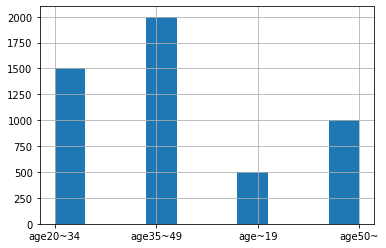

In [17]:
df_customers.age_cat.hist()

<AxesSubplot:>

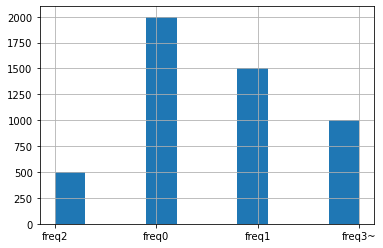

In [18]:
df_customers.freq_cat.hist()

In [19]:
df_customer_pivot = pd.pivot_table(data=df_customers, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
df_customer_pivot = df_customer_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
df_customer_pivot.index = df_customer_pivot.index.map(lambda x: x.replace('age', ''))

<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

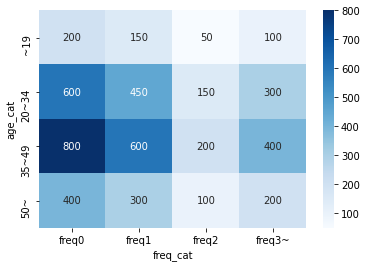

In [20]:
sns.heatmap(df_customer_pivot, annot=True, fmt='d', cmap='Blues')

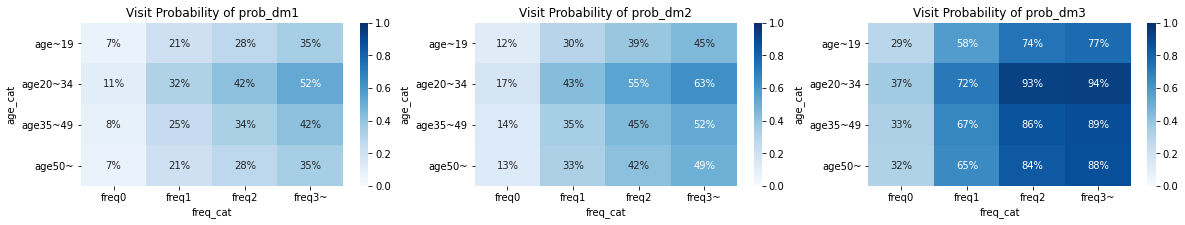

In [21]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20,3))
for i in range(3):
    ptn = f'prob_dm{i+1}'
    df_prob_pivot = pd.pivot_table(data = df_visit, values=ptn, columns='freq_cat', index='age_cat')
    df_prob_pivot = df_prob_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(df_prob_pivot, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

In [22]:
for i in range(3):
    col = f'name_dm{i+1}'
    df_customers[col] = [f'x_{customer_id}_{i+1}' for customer_id in df_customers.customer_id]
    df_visit[f'diff_prob_dm{i+1}'] = df_visit[f'prob_dm{i+1}'] - df_visit['prob_dm1']

price = {1:0, 2:1000, 3:2000}


df_merged = pd.merge(df_customers, df_visit)

def form_table(df, i):
    df_tmp = df[['customer_id', 'age_cat', 'freq_cat', 'segment_id', f'name_dm{i+1}', f'prob_dm{i+1}', f'diff_prob_dm{i+1}']].copy()
    df_tmp.columns = ['customer_id', 'age_cat', 'freq_cat', 'segment_id', 'name', 'prob', 'diff_prob']
    df_tmp['dm_type'] = i+1
    df_tmp['cost'] = df_tmp['dm_type'].map(price)
    return df_tmp



df_val = pd.concat([form_table(df_merged, i) for i in range(3)], axis=0)
df_val.sort_values(['customer_id', 'dm_type'], inplace=True)
df_val.reset_index(inplace=True, drop=True)

df_val['pri_cost'] = df_val.cost * df_val.prob

In [23]:
df_val

,customer_id,age_cat,freq_cat,segment_id,name,prob,diff_prob,dm_type,cost,pri_cost
0,1,age20~34,freq2,7,x_1_1,0.42,0.00,1,0,0.0
1,1,age20~34,freq2,7,x_1_2,0.55,0.13,2,1000,550.0
2,1,age20~34,freq2,7,x_1_3,0.93,0.51,3,2000,1860.0
3,2,age35~49,freq0,9,x_2_1,0.08,0.00,1,0,0.0
4,2,age35~49,freq0,9,x_2_2,0.14,0.06,2,1000,140.0
...,...,...,...,...,...,...,...,...,...,...
14995,4999,age50~,freq1,14,x_4999_2,0.33,0.12,2,1000,330.0
14996,4999,age50~,freq1,14,x_4999_3,0.65,0.44,3,2000,1300.0
14997,5000,age20~34,freq0,5,x_5000_1,0.11,0.00,1,0,0.0
14998,5000,age20~34,freq0,5,x_5000_2,0.17,0.06,2,1000,170.0


# Optimization

In [24]:
df_val['val'] = [pulp.LpVariable(n, cat='Binary') for n in df_val['name']]
df_val['pri_cost'] = df_val.prob * df_val.cost
df_val

,customer_id,age_cat,freq_cat,segment_id,name,prob,diff_prob,dm_type,cost,pri_cost,val
0,1,age20~34,freq2,7,x_1_1,0.42,0.00,1,0,0.0,x_1_1
1,1,age20~34,freq2,7,x_1_2,0.55,0.13,2,1000,550.0,x_1_2
2,1,age20~34,freq2,7,x_1_3,0.93,0.51,3,2000,1860.0,x_1_3
3,2,age35~49,freq0,9,x_2_1,0.08,0.00,1,0,0.0,x_2_1
4,2,age35~49,freq0,9,x_2_2,0.14,0.06,2,1000,140.0,x_2_2
...,...,...,...,...,...,...,...,...,...,...,...
14995,4999,age50~,freq1,14,x_4999_2,0.33,0.12,2,1000,330.0,x_4999_2
14996,4999,age50~,freq1,14,x_4999_3,0.65,0.44,3,2000,1300.0,x_4999_3
14997,5000,age20~34,freq0,5,x_5000_1,0.11,0.00,1,0,0.0,x_5000_1
14998,5000,age20~34,freq0,5,x_5000_2,0.17,0.06,2,1000,170.0,x_5000_2


In [25]:
problem = pulp.LpProblem('coupon', pulp.LpMaximize)


problem += pulp.lpDot(df_val[df_val.dm_type != 1].val, df_val[df_val.dm_type != 1].diff_prob)

for id in df_val.customer_id.drop_duplicates():
    problem += pulp.lpSum(df_val[df_val.customer_id == id].val) == 1

# df_val['pri_cost'] = df_val['pri_cost'] # scale normalize
problem += pulp.lpDot(df_val[df_val.pri_cost > 0].val, df_val[df_val.pri_cost > 0].pri_cost) <= 10**6

for seg in df_val.segment_id.drop_duplicates():
    df_val_sub = df_val[df_val.segment_id == seg]
    problem += pulp.lpSum(df_val_sub.val) >=  len(df_val_sub)/3/10


In [26]:
status = problem.solve()
print(f'Status: {pulp.LpStatus[status]}')


KeyboardInterrupt: 

In [ ]:
df_val['result'] = df_val.val.apply(lambda x: x.value())

In [ ]:
df_val

# Evaluation

In [ ]:
df_val.groupby('customer_id').result.sum().max()

In [ ]:
df_ratio = pd.merge(df_val.groupby('segment_id').count()['customer_id'], df_val.groupby('segment_id').result.sum(), right_index =True, left_index=True)
df_ratio['ratio'] = df_ratio.result/df_ratio.customer_id
df_ratio

In [ ]:
df_val['final_cost'] = df_val.cost * df_val.result
df_val.final_cost.sum()

In [ ]:
3333/3/10